In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
%matplotlib inline

In [207]:
base_dir = "/Users/Jackie/Dropbox/Work/machine_learning/hw/machine-learning-ex8/ex8"
data = loadmat(os.path.join(base_dir, 'ex8data1.mat'))
X = data['X']
Xval = data['Xval']
yval = data['yval'].ravel()

In [208]:
yval

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

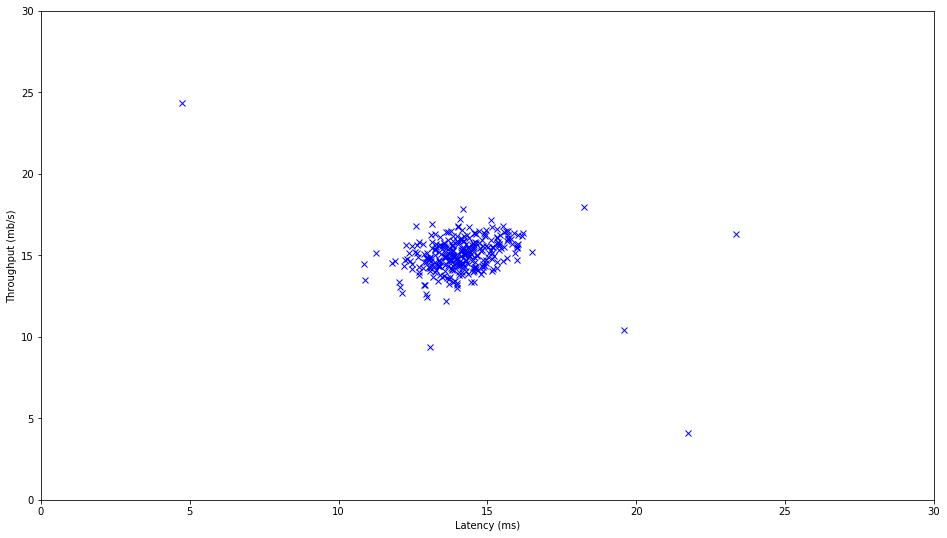

In [209]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(X[:, 0], X[:, 1], 'bx')
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (mb/s)')

In [210]:
# Estimate mu and sigma 
def estimateGaussian(X):
    """
    %ESTIMATEGAUSSIAN This function estimates the parameters of a 
    %Gaussian distribution using the data in X
    %   [mu sigma2] = estimateGaussian(X), 
    %   The input X is the dataset with each n-dimensional data point in one row
    %   The output is an n-dimensional vector mu, the mean of the data set
    %   and the variances sigma^2, an n x 1 vector
    %     
    """
    m, n = X.shape
    mu = np.mean(X, axis=0)
    sigma2 = np.std(X, axis=0) ** 2 
    return mu, sigma2

mu, sigma2 = estimateGaussian(X)

In [211]:
def multivariateGaussian(X, mu, sigma2):
    """
    %MULTIVARIATEGAUSSIAN Computes the probability density function of the
    %multivariate gaussian distribution.
    %    p = MULTIVARIATEGAUSSIAN(X, mu, Sigma2) Computes the probability 
    %    density function of the examples X under the multivariate gaussian 
    %    distribution with parameters mu and Sigma2. If Sigma2 is a matrix, it is
    %    treated as the covariance matrix. If Sigma2 is a vector, it is treated
    %    as the \sigma^2 values of the variances in each dimension (a diagonal
    %    covariance matrix)
    %    
    """
    k = len(mu)
    if len(sigma2.shape) == 1:
        sigma2 = np.diag(sigma2)         
    
    X = X - mu
    sigma2_det = np.linalg.det(sigma2)
    sigma2_inv = np.linalg.inv(sigma2)
    norm_const = (2*np.pi)**(-k/2) * sigma2_det ** (-0.5) 
    res = np.exp(-0.5 * np.sum(X.dot(sigma2_inv) *X, 1))
    p = norm_const * res
    return p 

p = multivariateGaussian(X, mu, sigma2)
print(np.max(p))
print(np.min(p))
p[:5]

0.08986095083415363
1.1812091168967608e-23


array([0.06470829, 0.05030417, 0.07245035, 0.05031575, 0.06368497])

In [212]:
def selectThreshold(yval, pval):
    """
    %SELECTTHRESHOLD Find the best threshold (epsilon) to use for selecting
    %outliers
    %   [bestEpsilon bestF1] = SELECTTHRESHOLD(yval, pval) finds the best
    %   threshold to use for selecting outliers based on the results from a
    %   validation set (pval) and the ground truth (yval).
    %   in yval, 1 means anormaly  
    """
    bestEpsilon = 0
    bestF1 = 0
    F1 = 0 
    pmax =np.max(pval)
    pmin =np.min(pval)
    stepsize = (pmax - pmin)/ 1000    
    for epsilon in np.arange(pmin, pmax+stepsize, stepsize):
        predicted = pval < epsilon
        
        tp = np.sum((predicted == 1) & (yval == 1)).astype(float) 
        fp = np.sum((predicted == 1) & (yval == 0)).astype(float) 
        fn = np.sum((predicted == 0) & (yval == 1)).astype(float)  
        precision = tp / (tp + fp)
        recall = tp /(tp + fn)
        
        F1 = 2 * precision * recall / (precision + recall)
                    
        if F1 > bestF1:
            bestF1 = F1
            bestEpsilon = epsilon 
    
    return bestEpsilon, bestF1

pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, f1 = selectThreshold(yval, pval)
print (epsilon, f1)
print("outliers found", np.sum(p < epsilon))

8.990852779269493e-05 0.8750000000000001
outliers found 6


/Users/Jackie/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


# Part 4: Multidimensional Outliers

In [213]:
data2 = loadmat(os.path.join(base_dir, 'ex8data2.mat'))

In [214]:
X = data2['X']
Xval = data2['Xval']
yval = data2['yval'].ravel()

In [215]:
mu, sigma2 = estimateGaussian(X)
print(X.shape, mu.shape, sigma2.shape)

(1000, 11) (11,) (11,)


In [216]:
p = multivariateGaussian(X, mu, sigma2)
pval = multivariateGaussian(Xval, mu, sigma2)
epsilon, F1 = selectThreshold(yval, pval)

/Users/Jackie/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [217]:
print(epsilon, F1)
print("outliers found", np.sum(p < epsilon))

1.3772288907613575e-18 0.6153846153846154
outliers found 117


# Collaborative Filtering

In [218]:
data = loadmat(os.path.join(base_dir, 'ex8_movies.mat'))

In [223]:
"""
%  Y is a 1682x943 matrix, containing ratings (1-5) of 1682 movies on 
%  943 users
%
%  R is a 1682x943 matrix, where R(i,j) = 1 if and only if user j gave a
%  rating to movie i
"""
Y = data['Y']
R = data['R']
print(Y.shape, R.shape)

(1682, 943) (1682, 943)


In [222]:
Y

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [224]:
R

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

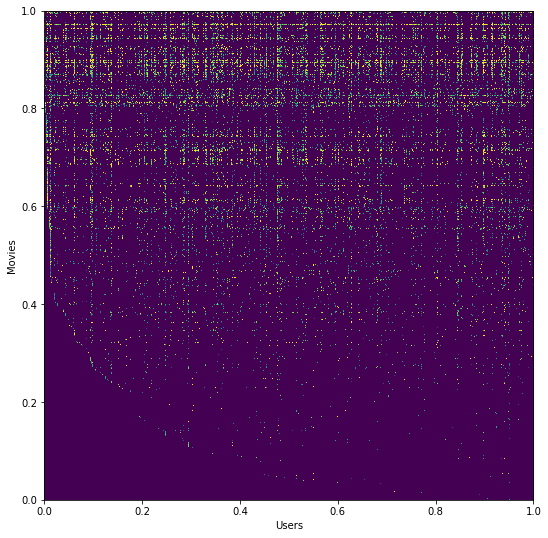

In [230]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(Y, extent=[0, 1, 0, 1])            
ax.set_xlabel("Users")
ax.set_ylabel("Movies")

In [310]:
data = loadmat(os.path.join(base_dir, 'ex8_movieParams.mat'))

In [311]:
Theta = data['Theta']
X = data['X']
num_features = data['num_features'][0][0]
num_movies = data['num_movies'][0][0]
num_users = data['num_users'][0][0]

In [312]:
num_users

943

In [238]:
num_users = 4; num_movies = 5; num_features = 3;
X = X[:num_movies, :num_features]
Theta = Theta[:num_users, :num_features]
Y = Y[:num_movies, :num_users]
R = R[:num_movies, :num_users]

In [261]:
print(Y)
print(X)
print(R)

[[5 4 0 0]
 [3 0 0 0]
 [4 0 0 0]
 [3 0 0 0]
 [3 0 0 0]]
[[ 1.0486855  -0.40023196  1.19411945]
 [ 0.78085123 -0.38562591  0.52119779]
 [ 0.64150886 -0.54785385 -0.08379638]
 [ 0.45361782 -0.80021844  0.68048129]
 [ 0.93753789  0.1060899   0.36195295]]
[[1 1 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]


In [268]:
def cofiCostFunc(parms, Y, R, num_users, num_movies, num_featuers, penalty):
    """
    %COFICOSTFUNC Collaborative filtering cost function
    %   [J, grad] = COFICOSTFUNC(params, Y, R, num_users, num_movies, ...
    %   num_features, lambda) returns the cost and gradient for the
    %   collaborative filtering problem.
    """
    # m = num_movies, k = num_features, n = num_users
    
    l = num_movies * num_features 
    
    X = parms[:l].reshape(num_movies, num_features) # m * k
    Theta = parms[l:].reshape(num_users, num_features) # n * k
    
    error = (X.dot(Theta.T) - Y) *R # m * n
    J = np.sum(np.power(error, 2)) /2  + penalty/2* np.sum(np.power(Theta, 2)) \
    + penalty/2* np.sum(np.power(X, 2))
    
    X_grad = error.dot(Theta) + penalty * X  # m * k
    Theta_grad = error.T.dot(X) + penalty * Theta # n*k
        
    grad = np.concatenate([X_grad.flatten(), Theta_grad.flatten()])
    return J, grad 
    
        

In [269]:
J, grad = cofiCostFunc(np.concatenate([X.flatten(), Theta.flatten()]) , 
                 Y, R, num_users, num_movies, num_features, 1.5)

In [271]:
print(J)
print(grad)

31.34405624427422
[ -0.95596339   6.97535514  -0.10861109   0.60308088   2.77421145
   0.25839822   0.12985616   4.0898522   -0.89247334   0.29684395
   1.06300933   0.66738144   0.60252677   4.90185327  -0.19747928
 -10.13985478   2.10136256  -6.76563628  -2.29347024   0.48244098
  -2.99791422  -0.64787484  -0.71820673   1.27006666   1.09289758
  -0.40784086   0.49026541]


# Learning Movie Ratings

In [443]:
movie_idx = []
with open(os.path.join(base_dir, 'movie_ids.txt'), 'rb') as f: 
    for line in f:
        tokens = [token.decode("ISO-8859-1")  for token in line.split()]
        #tokens[-1] = tokens[-1][:-1]
        movie_idx.append(' '.join(tokens[1:])) 
print(movie_idx[:5])        

['Toy Story (1995)', 'GoldenEye (1995)', 'Four Rooms (1995)', 'Get Shorty (1995)', 'Copycat (1995)']


In [444]:
ratings = np.zeros(m)
ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

for i, r in enumerate(ratings):
    if r > 0:
        print("rating for move %s is %s" %(movie_idx[i], r))
    

rating for move Toy Story (1995) is 4.0
rating for move Twelve Monkeys (1995) is 3.0
rating for move Usual Suspects, The (1995) is 5.0
rating for move Outbreak (1995) is 4.0
rating for move Shawshank Redemption, The (1994) is 5.0
rating for move While You Were Sleeping (1995) is 3.0
rating for move Forrest Gump (1994) is 5.0
rating for move Silence of the Lambs, The (1991) is 2.0
rating for move Alien (1979) is 4.0
rating for move Die Hard 2 (1990) is 5.0
rating for move Sphere (1998) is 5.0


In [445]:
data = loadmat(os.path.join(base_dir, 'ex8_movies.mat'))
Y = data['Y']
R = data['R']
print (Y.shape)
m = Y.shape[0]
Y = np.hstack([Y, ratings.reshape(-1, 1)])
R = np.hstack([R, (ratings !=0).reshape(-1, 1)])


(1682, 943)


In [446]:
def normalizeRatings(Y, R):
    m, n = Y.shape
    Ymean = np.zeros(m)
    Ynorm = np.zeros([m,n] )
    for i in range(m):
        idx = R[i, :]==1
        Ymean[i] = Y[i, idx].mean()
        Ynorm[i, idx] = Y[i, idx] - Ymean[i]
        
    return Ynorm, Ymean

In [447]:
Y_norm, Ymean = normalizeRatings(Y, R)

In [448]:
m, n = Y.shape
k = 10 

In [449]:
import scipy.optimize as opt
init_parms = np.concatenate([X.ravel(), theta.ravel()])
penalty = 10
X = np.random.randn(m, k)
theta = np.random.randn(n, k)
# minimize the objective function
fmin = opt.minimize(fun=cofiCostFunc, x0=init_parms, args=(Y_norm, R, n, m, k, penalty), jac=True, method='CG', options={'maxiter': 100})
X_prime = np.reshape(fmin.x[:(m*k)], (m, k))
theta_prime = np.reshape(fmin.x[(m*k):], (n, k))

# Recommendation for you

In [451]:
predictions = X_prime.dot(theta_prime.T)[:, -1] + Ymean
idx = np.argsort(predictions)[::-1]
print("top 10 recommened movies\n")
top_movies = np.array(movie_idx)[idx[:10]].reshape(-1, 1)
top_scores = predictions[idx[:10]].reshape(-1, 1)
print(np.hstack([top_movies, top_scores]), '\n')

for i, r in enumerate(ratings):
    if r > 0:
        print("rating for move %s is %s, predition is: %s" %(movie_idx[i], r, predictions[i] ))


top 10 recommened movies

[["Someone Else's America (1995)" '5.0000030705865015']
 ['Santa with Muscles (1996)' '5.000001042623582']
 ['Entertaining Angels: The Dorothy Day Story (1996)' '5.000000176760092']
 ['They Made Me a Criminal (1939)' '5.000000145919641']
 ['Star Kid (1997)' '4.999999915214624']
 ['Saint of Fort Washington, The (1993)' '4.9999998704008695']
 ['Marlene Dietrich: Shadow and Light (1996)' '4.9999998309739455']
 ['Aiqing wansui (1994)' '4.999999750163277']
 ['Great Day in Harlem, A (1994)' '4.99999723134891']
 ['Prefontaine (1997)' '4.999993948188811']] 

rating for move Toy Story (1995) is 4.0, predition is: 4.008139749682043
rating for move Twelve Monkeys (1995) is 3.0, predition is: 3.769317763947699
rating for move Usual Suspects, The (1995) is 5.0, predition is: 4.409421148586853
rating for move Outbreak (1995) is 4.0, predition is: 3.4202239100116905
rating for move Shawshank Redemption, The (1994) is 5.0, predition is: 4.551419694326167
rating for move While